# Transforms updating meta data

MONAI transforms update meta data as necessary when they are applied. This is done by storing the image as a `MetaTensor`, which is a child class of `torch.Tensor`, but it also contains information such as the meta data and the image's affine transformation matrix.

This allows us to perform some pre-processing transforms, infer an image with our network and then save the inferred segmentation to file. Although the output is different in terms of size and voxel spacing, the input image and output segmentation should align as expected in an external image viewer (a screenshot of ITKSnap is given, but any should do the trick).

We only use a single image in this training script. This allows us to obtain near-perfect results very quickly. The process would be exactly the same if more images were to be used.

## Imports

In [1]:
import os
from tqdm import trange
import torch
from glob import glob
import tempfile

import monai.transforms as mt
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.apps import download_and_extract

In [2]:
device = torch.device("cuda")

## Set up data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/mnt/data/rbrown/Documents/Data/MONAI


## Download the data

In [4]:
task = "Task01_BrainTumour"
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/" + task + ".tar"

compressed_file = os.path.join(root_dir, task + ".tar")
data_dir = os.path.join(root_dir, task)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

images = sorted(glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
labels = sorted(glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image, "label": label}
              for image, label in zip(images, labels)]
data = [data_dicts[0]]

## Transforms

Of those applied, we expect transforms such as `Orientationd`, `CropForegroundd`, `Spacingd`, and `DivisiblePadd` to all modify an images affine transformation matrix.

In [5]:
keys = ("image", "label")
t = mt.Compose([
    mt.LoadImaged(keys),
    mt.EnsureChannelFirstd(keys),
    mt.Orientationd(keys, "RAI"),
    mt.CropForegroundd(keys, source_key="image"),
    mt.Spacingd(keys, pixdim=[0.5, 0.5, 1], mode=("bilinear", "nearest")),
    mt.ScaleIntensityd("image"),
    mt.DivisiblePadd(keys, 8),
])

## Simple dataset and dataloader

In [6]:
ds = CacheDataset(data, transform=t)
dl = DataLoader(ds)

Loading dataset: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


## Quick training loop

In [7]:
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
).to(device)
loss_function = DiceLoss(softmax=True, to_onehot_y=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-2)

max_epochs = 50
tr = trange(max_epochs)
for epoch in tr:
    for batch in dl:
        inputs, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    tr.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.1242: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


## Post transforms

Infer a test image, perform argmax to get the class for each voxel, and then save the result to file.

In [8]:
out_path = tempfile.mkdtemp()

post_trans = mt.Compose([
    mt.AsDiscrete(argmax=True),
    mt.SaveImage(output_dir=out_path, output_ext=".nii", resample=False),
])
out = [post_trans(i) for i in decollate_batch(model(batch["image"].to(device))) for batch in dl]

2022-06-16 10:22:00,304 INFO image_writer.py:193 - writing: /tmp/tmppc6xwd66/BRATS_001/BRATS_001_trans.nii


ignoring the tracking transform info.


## Viewing results

If you load the input image and inferred segmentation in an external viewer, hopefully you should see that although the input and output images have different sizes and spacing, they are nicely aligned.

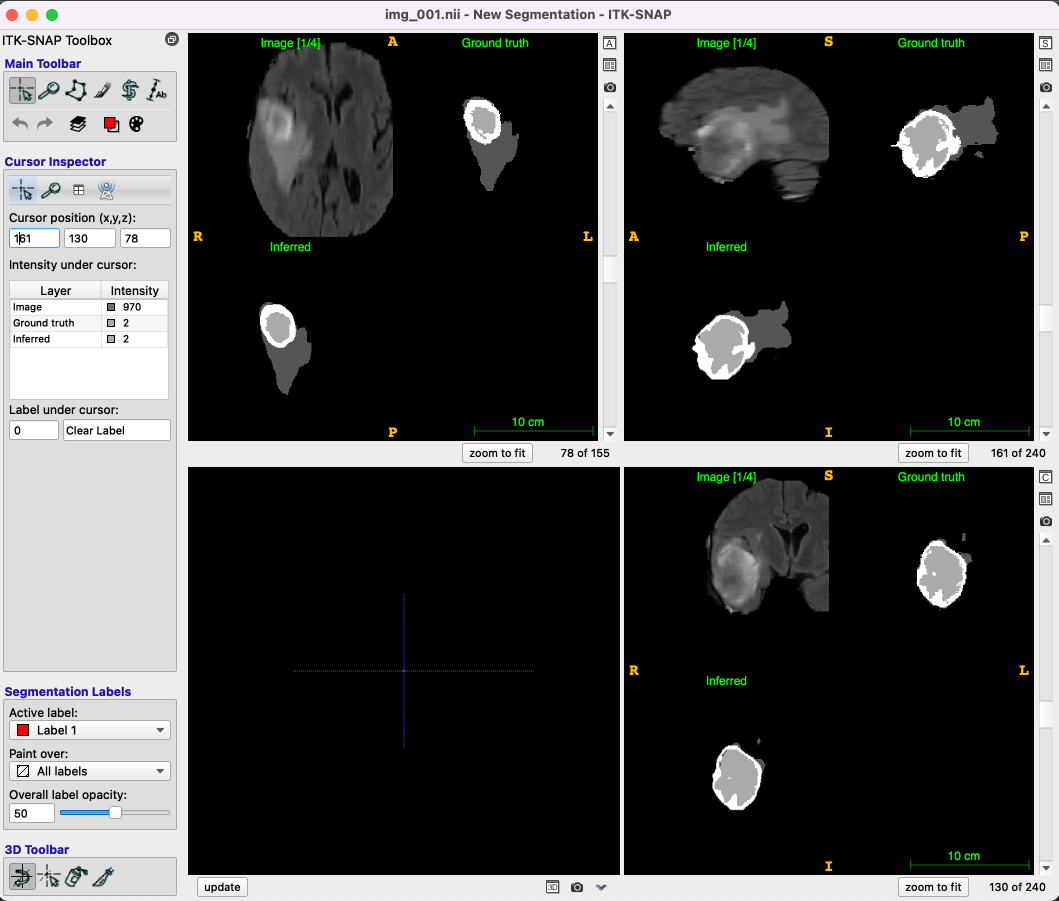